In [1]:
from reduction import *
class map_reduction:
    def __init__(self, inst):
        self.inst = inst
        self.DCtemplate, self.mask_inst = self.get_DC_mask_inst(self.inst)
        self.ts_process()     
        self.get_strmask(self.inst)
        ## FF corr
        ## hand mask
        
    def ts_process(self):
        stackmapdat = {}
        for ifield in [4,5,6,7,8]:
            stackmapdat[ifield] = {}
            tsmask = self.get_tsmask(self.inst, ifield)
            linmap, negmask, long = self.linearized_map(self.inst, ifield)
            mask = self.mask_inst * tsmask * negmask
            
            stackmapdat[ifield]['rawmap'] = long
            stackmapdat[ifield]['rawmask'] = mask
            stackmapdat[ifield]['DCsubmap'] = linmap - self.DCtemplate
        
        self.stackmapdat = stackmapdat
    
    def get_strmask(self, inst):

        fname = mypaths['alldat'] + 'TM'+ str(inst) + '/strmaskdat'
        try:
            strmaskdat = np.load(fname + '.npy')
        except OSError as error:
            strmasks, strnums = [], []

            for ifield in [4,5,6,7,8]:
                strmask, strnum = Ith_mask(inst, ifield)
                strmasks.append(strmask)
                strnums.append(strnum)

            strmaskdat = np.stack((np.array(strmasks), np.array(strnums)))
            np.save(fname,strmaskdat)

        for i,ifield in enumerate([4,5,6,7,8]):
            strmask, strnum = strmaskdat[0,i,...], strmaskdat[1,i,...]
            self.stackmapdat[ifield]['strmask'] = strmask
            self.stackmapdat[ifield]['strnum'] = strnum

    def get_DC_mask_inst(self, inst):
        inst = self.inst
        DCdir = mypaths['ciberdir'] + 'doc/20160808_DarkProcess/40030/'
        DCtemplate = loadmat(DCdir + 'band' + str(inst) + '_DCtemplate.mat')['DCtemplate']
        mask_inst = loadmat(DCdir + 'band' + str(inst) + '_mask_inst.mat')['mask_inst']
        return DCtemplate, mask_inst
    
    def get_tsmask(self, inst, ifield):
        '''
        Mask bad time-stream pixels
        '''
        frames = get_frame_data().get_frames(inst, ifield)

        Nfr = frames.shape[0]
        dframes = frames[1:] - frames[:-1]

        # mask the pixel there is ts diff > 5e4
        diff_clip_mask = np.zeros_like(dframes)
        diff_clip_mask[np.where(abs(dframes) > 5e4)] = 1
        diff_clip_mask = np.sum(diff_clip_mask, axis=0)

        # mask the pixel if there is ts diff > 100 * median ts diff
        diff_median = np.median(abs(dframes), axis=0)
        diff_median_stack = np.repeat(diff_median[np.newaxis,...], Nfr-1, axis=0)
        med_clip_mask = np.zeros_like(dframes)
        med_clip_mask[np.where(abs(dframes) > 100*diff_median_stack)] = 1
        med_clip_mask = np.sum(med_clip_mask, axis=0)
        med_clip_mask[diff_median==0] = 1

        tsmask = np.ones_like(med_clip_mask)
        tsmask[diff_clip_mask!=0] = 0
        tsmask[med_clip_mask!=0] = 0

        return tsmask

    def _frame_linefit(self, frames, return_offset=False):

        Nfr,Npix = frames.shape[:2]
        poly = np.polynomial.polynomial.polyfit(np.arange(Nfr), frames.reshape(Nfr,-1), 1)
        poly = poly.reshape(2,Npix,Npix)

        if return_offset:
            return poly[1,...], poly[0,...]

        return poly[1,...]

    def linearized_map(self, inst, ifield):
        frames = get_frame_data().get_frames(inst, ifield)

        th = -5000
        if ifield == 5:
            frames = frames[-10:]
            th = -2000

        Nfr,Npix = frames.shape[:2]
        long, off = self._frame_linefit(frames, return_offset=True)
        short = self._frame_linefit(frames[:4])

        # mask negative pixel
        negmask = np.ones((Npix, Npix))
        negmask[long>0] = 0

        # linearize
        linmap = long.copy()
        linmap[(frames[-1] - off) < th] = short[(frames[-1] - off) < th]

        return linmap, negmask, long

In [ ]:
for ifield in [4,5,6,7,8]:
    FF = 

In [2]:
data = map_reduction(1)

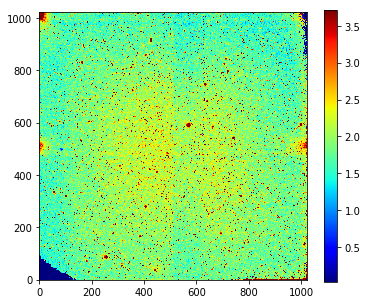

In [13]:
imageclip(-data.stackmapdat[8]['DCsubmap'])

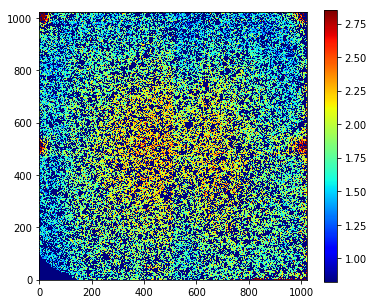

In [12]:
imageclip(-data.stackmapdat[8]['strmask']*data.stackmapdat[8]['DCsubmap'])